# Build and train a CNN 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm
import datetime
import time
import pickle

### Check whether able to see GPU

In [2]:
k.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Allocate only required amount of GPU memory

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Defining Image Dimensions and Locations

In [4]:
# image dimension (n_pixl x n_pixl)
n_pixl=128
batch_size=50
include_LG_data=False
RepoDir = '/home/user1/Dropbox/Academic/WORK/Beam_auto_alignment/'
TrainingDataFolder = RepoDir + 'Data/TrainingData/'
SaveModelFolder = RepoDir + 'Data/TrainedModels/'

In [5]:
files = os.listdir(TrainingDataFolder)
for file in files:
    if file[-3:] != 'png':
        files.remove(file)

In [6]:
Labels = []
# We have grayscale images, so while loading the images we will keep grayscale=True, 
# if you have RGB images, you should set grayscale as False
Images = []
for file in tqdm(files):
    if not include_LG_data:
        if file[:2] == 'LG':
            continue
    # training images
    img = image.load_img(TrainingDataFolder+file, \
                         target_size=(n_pixl,n_pixl,1), color_mode="grayscale")
    img = image.img_to_array(img)
    img = img/255
    Images.append(img)
    # target labels
    Labels.append(file[:6])

X = np.array(Images)

100%|██████████| 24423/24423 [00:03<00:00, 7830.40it/s]


In [7]:
Y = np.array(Labels)
Label_enc = LabelEncoder()
Y = Label_enc.fit_transform(Y)
Y = Y.reshape(len(Y), 1)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
Y = onehot_encoder.fit_transform(Y)
Y.shape
# Collect the encoders in a dict to save later
Encoder = {'one_hot_enc': onehot_encoder, 'label_enc': Label_enc}

24

### split data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=297, test_size=0.2, shuffle=True)

## Build CNN

In [26]:
# Define the model structure
n_cv_filts = 64  # number of convolutional filters
n_cv_filts2 = 32  # number of convolutional filters
n_cv = 3  # conv filter kernel size
n_mp = 2  # 
dp1 = 0.25
n_d = 128
dp2 = 0.5

# CNN
model = Sequential()
model.add(Conv2D(n_cv_filts, kernel_size=n_cv, \
                 input_shape=(n_pixl,n_pixl,1), data_format="channels_last"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(n_cv_filts2, kernel_size=n_cv))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=n_mp))
model.add(Dropout(dp1))

model.add(Conv2D(n_cv_filts2, kernel_size=n_cv))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(n_cv_filts2, kernel_size=n_cv))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=n_mp))
model.add(Dropout(dp1))

model.add(Flatten())
model.add(Dense(n_d))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(dp2))
model.add(Dense(len(np.unique(np.array(Labels))), activation='softmax'))

## Training

In [35]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adadelta', \
              metrics=['accuracy'])

Model_Name = 'Trained_Model_' + \
           str(datetime.datetime.now()).replace(' ', '_').replace(':', '-')[:-10]

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath = SaveModelFolder + Model_Name + '_checkpoints.hdf5', \
                               verbose=1, save_best_only=True)
# Training the model
fit_history = model.fit(X_train, y_train, epochs=40, batch_size=batch_size, \
                        shuffle=True, validation_data=(X_test, y_test))

Train on 9773 samples, validate on 2444 samples
Epoch 1/40
9773/9773 [==============================] - 8s 868us/step - loss: 0.4714 - acc: 0.8806 - val_loss: 0.1770 - val_acc: 0.9456
Epoch 2/40
9773/9773 [==============================] - 8s 813us/step - loss: 0.2005 - acc: 0.9293 - val_loss: 0.0735 - val_acc: 0.9808
Epoch 3/40
9773/9773 [==============================] - 8s 817us/step - loss: 0.1750 - acc: 0.9388 - val_loss: 0.1080 - val_acc: 0.9701
Epoch 4/40
9773/9773 [==============================] - 8s 794us/step - loss: 0.4368 - acc: 0.9057 - val_loss: 0.0727 - val_acc: 0.9791
Epoch 5/40
9773/9773 [==============================] - 8s 797us/step - loss: 0.2151 - acc: 0.9355 - val_loss: 0.1187 - val_acc: 0.9685
Epoch 6/40
9773/9773 [==============================] - 8s 797us/step - loss: 0.1203 - acc: 0.9598 - val_loss: 0.0558 - val_acc: 0.9840
Epoch 7/40
9773/9773 [==============================] - 8s 789us/step - loss: 0.1233 - acc: 0.9597 - val_loss: 0.0656 - val_acc: 0.9816


### Testing

In [61]:
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
test_predict = model.predict(X_test)
print("Testing Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

2444/2444 [==============================] - 1s 300us/step
Testing Accuracy: 99.14%
Loss: 0.04454495871355909


## Code for visualization of the Accuracy and Loss:

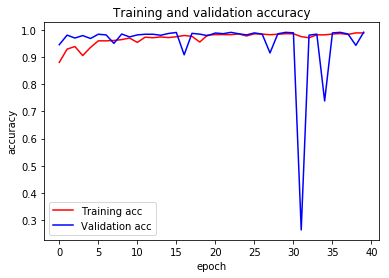

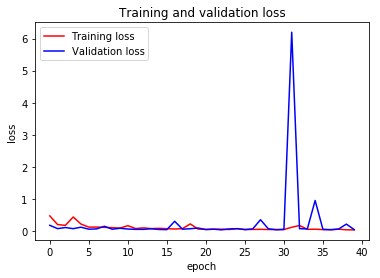

In [37]:
#Graphing our training and validation
acc = fit_history.history['acc']
val_acc = fit_history.history['val_acc']
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

## Confusion Matrix

In [62]:
# Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to 
# return the column
# label of the maximum value thus creating a categorical variable
# Basically, flipping a dummy variable back to it's categorical variable

categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(test_predict).idxmax(axis=1)

cm = confusion_matrix(categorical_test_labels, categorical_preds)

Normalized confusion matrix


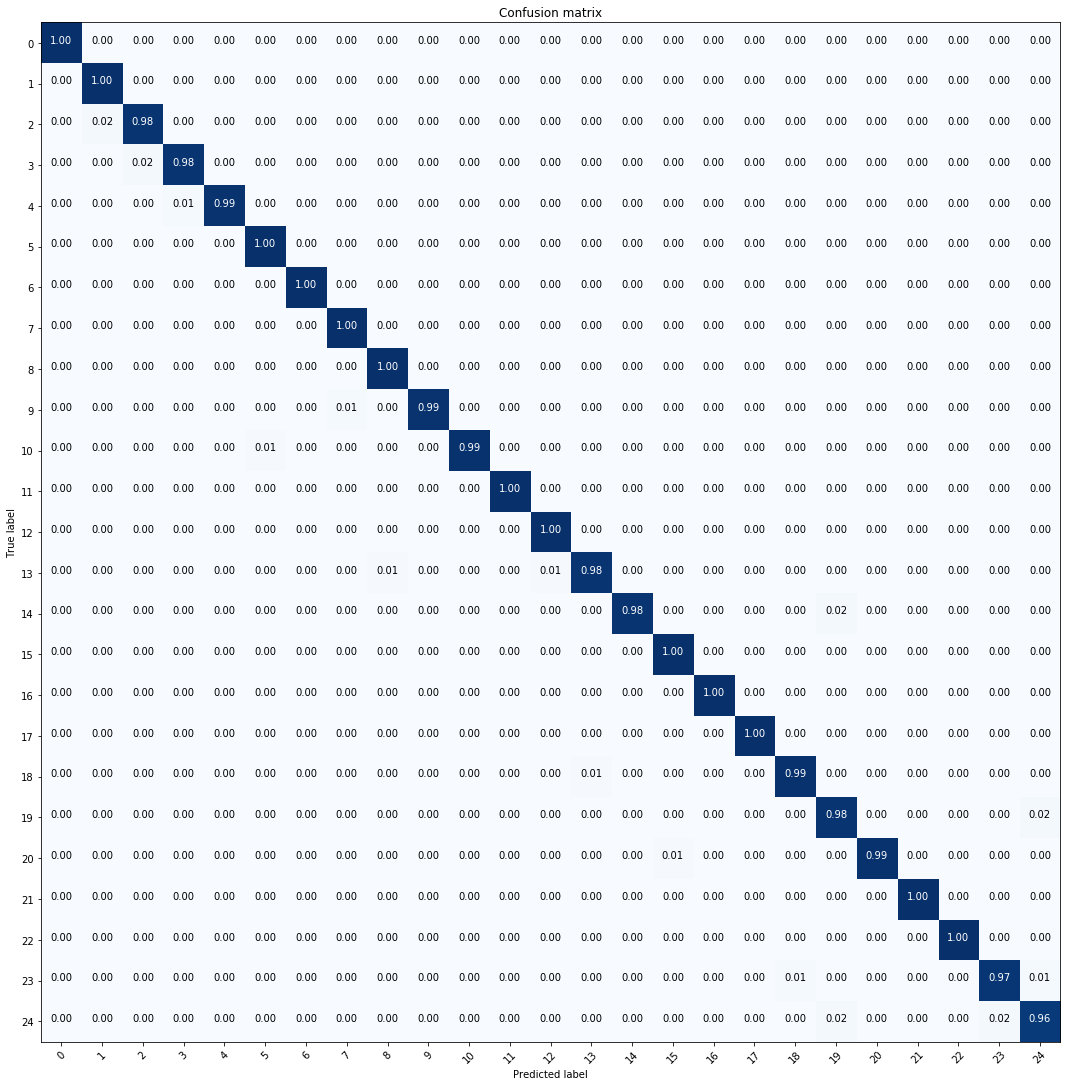

In [63]:
def plot_confusion_matrix(cm, classes,
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues, colrbar=False, savefig=True):
    
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
    else:
     print('Confusion matrix, without normalization')
    # Plotting
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if colrbar: plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", \
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(SaveModelFolder + 'Conf_Mat_of_' + Model_Name + '.png')

# Plot Confusion Mat
plot_confusion_matrix(cm, np.arange(len(np.unique(np.array(Labels)))))

### Save the model

In [52]:
model.save(SaveModelFolder + Model_Name + '.h5')
print("Model Saved: {}".format(SaveModelFolder + Model_Name + '.h5'))

Model Saved: /home/user1/Dropbox/Academic/WORK/Beam_auto_alignment/Data/TrainedModelsTrained_Model_2019-07-03_17-15.h5


### Save the Label Encoder

In [ ]:
pickle.dump(Encoder, open(SaveModelFolder + 'Encoder_of_' + Model_Name + '.npy', 'wb'))